# Introduction
In this online version of the FP experiment "Neuromorphic Computing" you will access the neuromorphic chip *Spikey* through a web-based platform that is provided by the Human Brain Project (HBP). The web-based access is provided by the HBP "Collaboratory" which provides access to the HBP's research infrastructure (also called *Platforms*).

Access is organized in so-called *Collabs* (similar to shared online documents) - in this case we access the "neuromorphic computing platform". Experiments are defined using Python scripts in Jupyter notebooks, using the PyNN API. This is the basic experiment setup, illustrated also in below figure (preliminary):
* The Jupyter notebook (JupyterHub) is effectively run on a connected computing facility, in our case the Jülich Supercomuting Centre (Forschungszentrum Jülich)
* Experiment code is written into a separate Python file
* A compute job is submitted to the platform, which schedules and executed the included Python file
* Data that is generated by the experiment is transferred back into the notebook and can be evaluated/visualized.

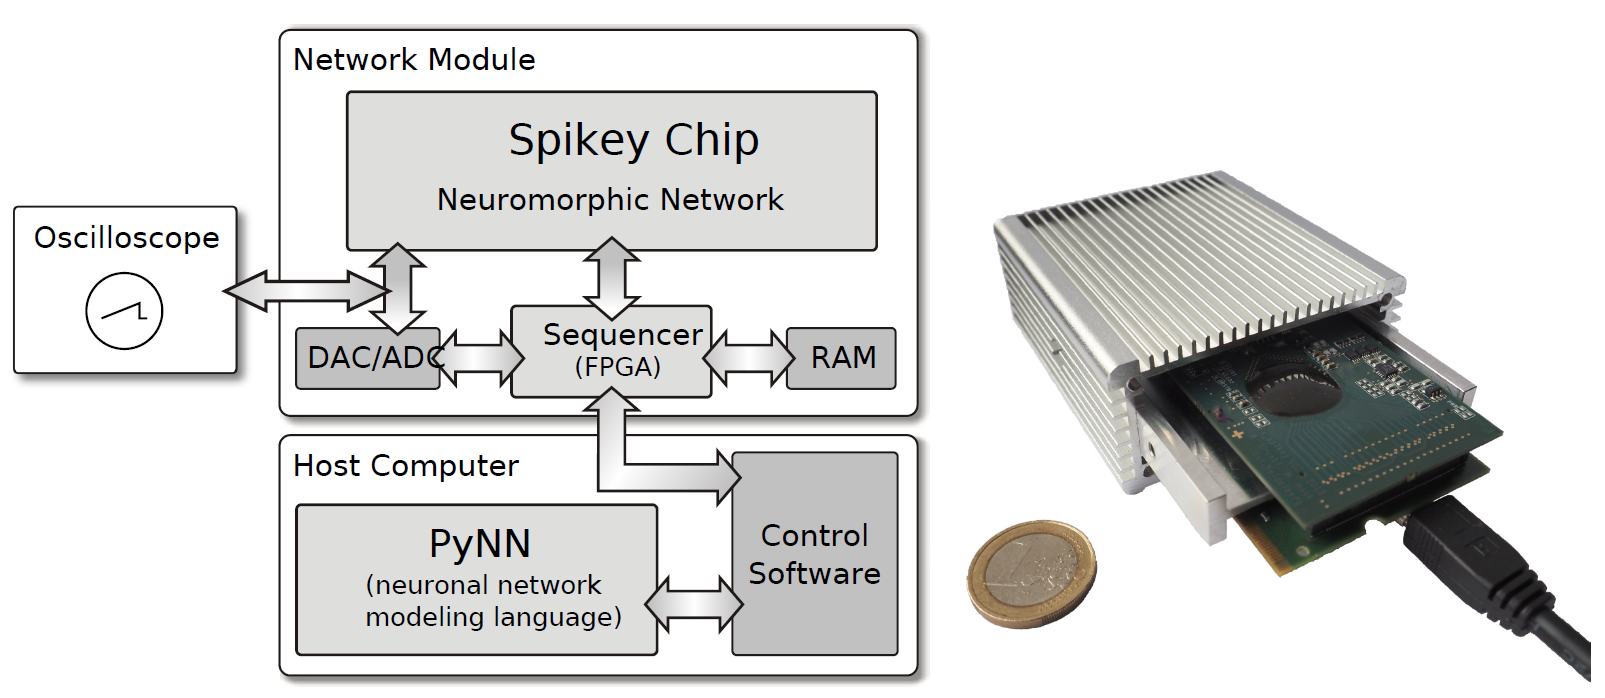

## The network
The next cell writes (with the magic first line %%writefile...) the network description script fp_task1.py. This file will be sent to the host that executes the experiment on the chip. Therefore, all variables that are required for the experiment need to be declared in this same cell.

In [1]:
#!/usr/bin/env python
# coding: utf-8

'''
Fortgesschrittenenpraktikum F09/10 - Neuromorphic Computing
Task 2 - Calibrating Neuron Parameters

Andreas Gruebl, July 2016, agruebl@kip.uni-heidelberg.de
-> adapted to HBP collaboratory usage, April 2020
'''

# load PyNN interface for the Spikey neuromorphic hardware
import numpy as np
import pyNN.hardware.spikey as pynn

####################################################################
# experiment parameters
# in biological time and parameter domain
####################################################################

use_other_spikey_half = False
runtime = 200.0  # ms -> 0.1ms on hardware

neuronParams = {
    'v_reset'   : -80.0,  # mV
    'e_rev_I'   : -75.0,  # mV
    'v_rest'    : -50.0,  # mV - default is -75.0 mV
    'v_thresh'  : -55.0,  # mV
    'g_leak'    :  20.0   # nS  -> tau_mem = 0.2nF / 20nS = 10ms
}

####################################################################
# procedural experiment description
####################################################################

# necessary setup - do not load calibration of membrane time constant
# (i.e. g_leak) because we want to do this manually.
if use_other_spikey_half:
    neuron_offset = 192
else:
    neuron_offset = 0
pynn.setup(calibTauMem=False, mappingOffset=neuron_offset)

# set up one neuron
neuron = pynn.Population(1, pynn.IF_facets_hardware1, neuronParams)

# increase refractory period by reducing hardware parameter icb
# -> play around with this parameter to obtain a visible refractory period.
#    it is a technical parameter only, with no direct translation to
# biological parameters! value range is from 0 to 2.5
pynn.hardware.hwa.setIcb(0.2)

# define which observables to record
# spike times (digital: neuron number and time stamp)
neuron.record()

# membrane potential (analog: digitized membrane voltage over time)
pynn.record_v(neuron[0], '')

# execute the experiment
pynn.run(runtime)

pynn.end()

# save results for offline processing
print "storing results"
np.savetxt("spikes.txt", neuron.getSpikes())
# in this PyNN-Version we cannot read membranes as 2D-lists...
np.savetxt("membrane_v.txt", pynn.membraneOutput)
np.savetxt("membrane_time.txt", pynn.timeMembraneOutput)

print "done"


/home/agtest/lib/python2.7/site-packages/pyNN/random.py:25: UserWarning: GSL random number generators not available
  warnings.warn("GSL random number generators not available")


storing results
done


# Data Visualization
The files that have been generated by the submitted job are now available to this notebook and can be used for evaluation and visualization.

NOTE: This cell initially has to be executed twice, to make the plot display within the notebook. Please give feedback to A. Gruebl, should you have a solution to this behavior.

average membrane potential: -68.4906383485 mV
sampling step for membrane potential: 0.104166666667 ms


<IPython.core.display.Javascript object>


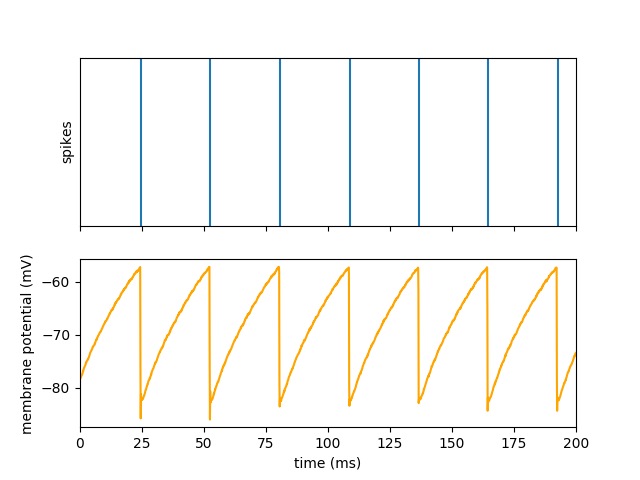

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

# has been defined for the experiment - redefine:
runtime = 200

# read data from files:
membrane_v =    np.loadtxt("./membrane_v.txt")
membrane_time = np.loadtxt("./membrane_time.txt")
spikes =        np.loadtxt("./spikes.txt", ndmin=2)[:, 1]

print 'average membrane potential:', np.mean(membrane_v), 'mV'
print 'sampling step for membrane potential: {} ms'.format(
                                membrane_time[1] - membrane_time[0])

# draw raster plot
ax = plt.subplot(211)  # row, col, nr
for spike in spikes:
    ax.axvline(x=spike)
ax.set_xlim(0, runtime)
ax.set_ylabel('spikes')
ax.set_xticklabels([])
ax.set_yticks([])
ax.set_yticklabels([])

# draw membrane potential
axMem = plt.subplot(212)
axMem.plot(membrane_time, membrane_v, c='orange')
axMem.set_xlim(0, runtime)
axMem.set_xlabel('time (ms)')
axMem.set_ylabel('membrane potential (mV)')

plt.show()
plt.savefig('fp_task1_1membrane.png')

In [3]:
# using FileLink, you can download results to your computer.
# For example:
from IPython.display import FileLink, FileLinks
FileLink("./fp_task1_1membrane.png")

/home/agtest/fp-spikey/notebooks/fp_task1_1membrane.png